In [110]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.measure import regionprops_table, label
from scipy.optimize import curve_fit

pixel_scale = 4 # arsec/pix
kpA = 1./206.265 # pc/arcsec


def objective(x, K, D):
	return K * x**(D/2.)

y = 8.08406 * x**(1.44397/2.)
y = 8.47145 * x**(1.43672/2.)
y = 3.00696 * x**(1.60872/2.)
y = 1.02667 * x**(1.82643/2.)
y = 0.76015 * x**(1.89556/2.)
y = 1.55870 * x**(1.61986/2.)


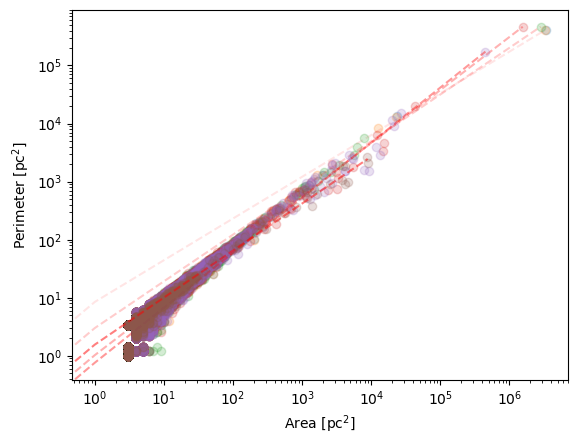

In [111]:
hdu = fits.open('/home/aellien/Euclid_LSB_DR1/wavelets/out3/mosaic_dawis_residuals_bin40.fits')
mosaic = hdu[1].data
mosaic = mosaic[2773-1000:2773+1000, 2813-1000:2813+1000]

plt.figure()

isol = [ 0.001, 0.005, 0.1, 0.3, 0.5, 1.0 ]
for i, iso in enumerate(isol):
    m = np.copy(mosaic)
    m[m<iso] = 0.
    m[m>=iso] = 1.
    lab = label(m)
    props = regionprops_table(lab, mosaic, properties=['area', 'perimeter'])

    perimeter_pc = props['perimeter']# * pixel_scale * kpA # pc
    area_pc = props['area']# * pixel_scale**2 * kpA**2
    plt.plot(area_pc, perimeter_pc, 'o', alpha = 0.2)

    #perimeter_pc = perimeter_pc[area_pc > 0.1]
    #area_pc = area_pc[area_pc > 0.1]
    
    popt, _ = curve_fit(objective, area_pc, perimeter_pc)
    # summarize the parameter values
    K, D = popt
    print(r'y = %.5f * x**(%.5f/2.)' % (K, D))
    x_line = np.arange(0, np.max(area_pc), 1)
    # calculate the output for the range
    y_line = objective(x_line, K, D)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color='red', alpha = 0.1 * i )

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Area [pc$^{2}$]')
plt.ylabel('Perimeter [pc$^{2}$]')
plt.show()

    

/home/aellien/anaconda3/envs/jwst-env/lib/python3.11/site-packages/skimage/measure/_label.py:120: RuntimeWarning: invalid value encountered in cast
  return clabel(label_image, background, return_num, connectivity)


y = 8.80660 * x**(0.89207/2.)
y = 2.13821 * x**(1.37860/2.)
y = 2.58290 * x**(1.27462/2.)
y = 1.16190 * x**(1.77036/2.)
y = 0.13255 * x**(2.88044/2.)


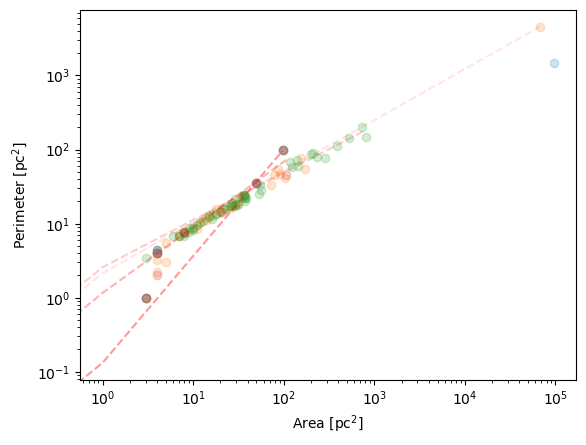

In [112]:
hdu = fits.open('~/Euclid_LSB_DR1/data/IR_EDF_N/mosaic_857GHz.fits')
mosaic = hdu[0].data
mosaic = mosaic[40:360, 20:320]
mosaic[mosaic == 0] = np.nan

plt.figure()

isol = [ 1.5, 2.0, 2.5, 3.0, 3.5 ]
for i, iso in enumerate(isol):
    m = np.copy(mosaic)
    m[m<iso] = 0.
    m[m>=iso] = 1.
    lab = label(m)
    props = regionprops_table(lab, mosaic, properties=['area', 'perimeter'])

    perimeter_pc = props['perimeter']# * pixel_scale * kpA # pc
    area_pc = props['area']# * pixel_scale**2 * kpA**2
    plt.plot(area_pc, perimeter_pc, 'o', alpha = 0.2)

    #perimeter_pc = perimeter_pc[area_pc > 0.1]
    #area_pc = area_pc[area_pc > 0.1]
    
    popt, _ = curve_fit(objective, area_pc, perimeter_pc)
    # summarize the parameter values
    K, D = popt
    print(r'y = %.5f * x**(%.5f/2.)' % (K, D))
    x_line = np.arange(0, np.max(area_pc), 1)
    # calculate the output for the range
    y_line = objective(x_line, K, D)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color='red', alpha = 0.1 * i )

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Area [pc$^{2}$]')
plt.ylabel('Perimeter [pc$^{2}$]')
plt.show()


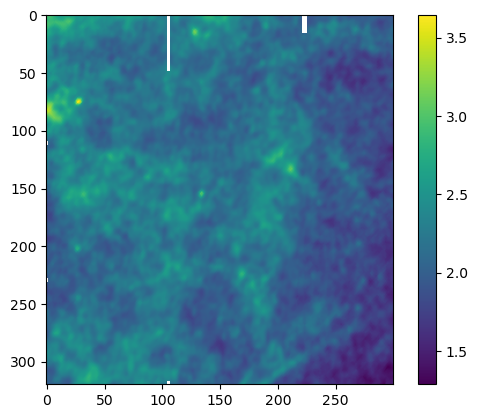

In [113]:
plt.figure()
plt.imshow(mosaic)
plt.colorbar()
plt.show()

(2000, 2000)


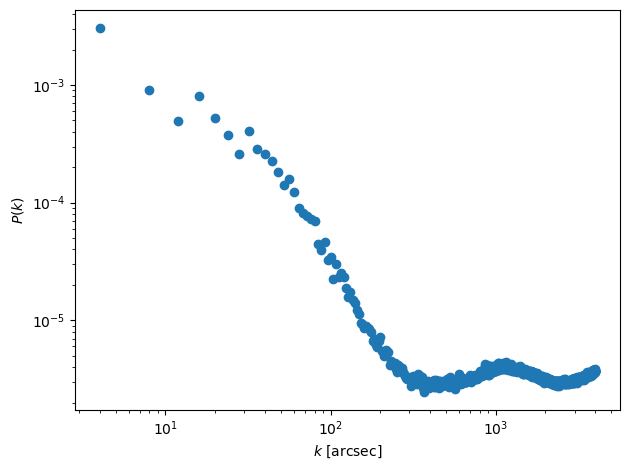

In [129]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as pl

hdu = fits.open('~/Euclid_LSB_DR1/data/IR_EDF_N/mosaic_857GHz.fits')
mosaic = hdu[0].data
image = mosaic[:300, :300]

hdu = fits.open('/home/aellien/Euclid_LSB_DR1/wavelets/out3/mosaic_dawis_residuals_bin40.fits')
mosaic = hdu[1].data
image = mosaic[2773-1000:2773+1000, 2813-1000:2813+1000]

print(image.shape)
npix = image.shape[0]

fourier_image = np.fft.fftn(image)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

pl.loglog(kvals * pixel_scale, Abins * 1E-14, 'o') # same units as 
pl.xlabel("$k$ [arcsec]")
pl.ylabel("$P(k)$")
pl.tight_layout()
pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

[[ 1.18926241e+06     +0.j         -1.79170608e+05 +54139.94131402j
  -1.42142126e+05 +28334.04703849j ... -3.60109007e+04  +2184.41600012j
  -1.42142126e+05 -28334.04703849j -1.79170608e+05 -54139.94131402j]
 [-2.68813243e+05-140309.95272066j -1.36428826e+05 -57275.80561751j
   4.22454655e+03 +25309.76205541j ...  9.17243812e+03 -53961.69235825j
   1.45656123e+04 -14326.85462918j  2.11860525e+05  -1829.19706771j]
 [-3.27663175e+04+130357.62937402j -6.49990296e+02 -20692.40969602j
  -2.44782136e+04 -48710.55797383j ...  6.76248639e+04 +55127.25728227j
  -2.43829698e+04 +41483.82846058j  5.42547653e+04   -622.42463547j]
 ...
 [ 3.11208936e+04 -20530.20444776j  2.21782919e+04 +32013.33172557j
  -1.57111333e+04 +28368.10692595j ...  2.87951462e+04 -83283.49714283j
  -6.08629965e+04 -85046.62312015j  2.55701191e+04 -52365.23431401j]
 [-3.27663175e+04-130357.62937402j  5.42547653e+04   +622.42463547j
  -2.43829698e+04 -41483.82846058j ... -1.41360666e+04 -63701.65224003j
  -2.44782136e+04 +

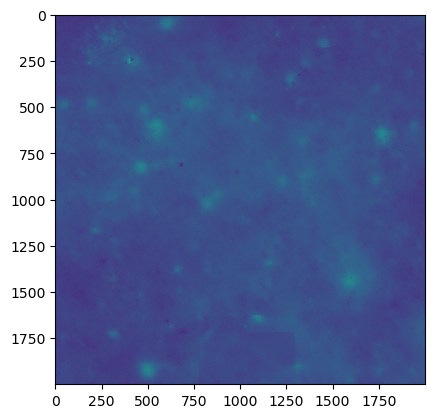

In [125]:
print(fourier_image)
plt.figure()
plt.imshow(image)
plt.show()